 # MNIST with pytorch

In [2]:
import torch
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

## Load the data

In [5]:
batch_size = 8192
validation_size = 10000

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,transform=torchvision.transforms.ToTensor())
mnist_trainset,mnist_valset = torch.utils.data.random_split(mnist_trainset, [len(mnist_trainset)-10000,10000])
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,transform=torchvision.transforms.ToTensor())

In [7]:
mnist_trainset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
mnist_trainset

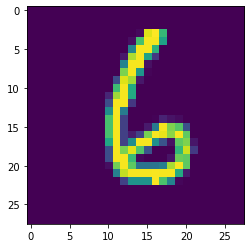

In [9]:
plt.imshow(mnist_trainset[0][0][0])

In [34]:
train_loader = DataLoader(
    mnist_trainset,
    num_workers=2,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    mnist_valset,
    num_workers=2,
    batch_size=len(mnist_valset),
    shuffle=True
)

test_loader = DataLoader(
    mnist_testset,
    num_workers=2,
    batch_size=len(mnist_testset),
    shuffle=True
)

In [11]:
batch_idx, (example_data, example_targets) = next(enumerate(train_loader))

## define the neural net

In [13]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.linear1 = nn.Linear(13*13*20,100) 
        self.linear2 = nn.Linear(100,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.linear1(x.view(-1,13*13*20))
        x = self.linear2(x)
        return x

In [14]:
model = Model1()

In [15]:
model(example_data[0:4]).shape

torch.Size([4, 10])

In [18]:
optimizer = optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
loss_func = nn.CrossEntropyLoss() 
val_frequency = 2

We are using CrossEntropyLoss() it did the softmax so ne need to add it in the model

In [19]:
losses_train = []
losses_val = []

In [100]:
%%time
epochs = 10
for epoch in range(epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        data.to(device)
        output = model(data)
        loss = loss_func(output, targets)
        loss.backward()
        optimizer.step()

    if (epoch == 0 or epoch%val_frequency == 0 or epoch == epochs-1):

        with torch.no_grad():
            _,(val_data, val_targets) = next(enumerate(train_loader))
            val_data.to(device)
            output_val = model(val_data)
            loss_val = loss_func(output_val, val_targets)
        losses_train.append(loss.item())
        losses_val.append(loss_val.item())
        print(f"Epoch {epoch}, loss_train {loss.item()}, loss_val {loss_val.item()}")
              

Epoch 0, loss_train 0.2452169805765152, loss_val 0.21802029013633728
Epoch 2, loss_train 0.22935277223587036, loss_val 0.22572286427021027
Epoch 4, loss_train 0.18959254026412964, loss_val 0.20727139711380005
Epoch 6, loss_train 0.24312280118465424, loss_val 0.23398639261722565
Epoch 8, loss_train 0.20261269807815552, loss_val 0.24133381247520447
Epoch 9, loss_train 0.23524253070354462, loss_val 0.23156452178955078
CPU times: user 4min 3s, sys: 1min 33s, total: 5min 36s
Wall time: 1min 46s


Total epoch : 476


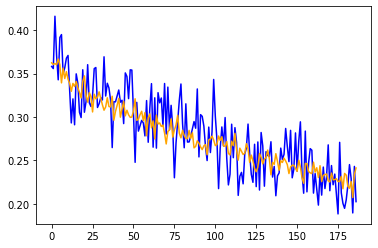

In [102]:
plt.plot(losses_train[50:-1],color="blue")
plt.plot(losses_val[50:-1],color="orange")  
print(f"Total epoch : {len(losses_train)*val_frequency}")

In [97]:
def output_model(data):
    return F.log_softmax(model(data),dim=1).max(dim=1)[1]

def score(data,target):
    return torch.true_divide((output_model(data) == target).sum(),len(data))
    

In [98]:
_, (test_data, test_targets) = next(enumerate(test_loader))

In [99]:
score(test_data,test_targets)

tensor(0.9375)

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'losses_train': losses_train,
            'losses_val'
            ...
            }, PATH)